## Acquire images

This notebook will:

* Section 1: For a given bounding box and year, find all SAR images in that region. Get some stats on them
* Section 2: Filter out images from scenes that don't have sufficient preceding winter imagery for melt detection
* Section 3: Run ASF Hyp3 RTC processing
* Section 4: Download the data. Reproject it immedately and save only the smaller image. Does that work? I thought I would have to have EPSG vals? This will have to get figured out

### Preamble
Prepare to do stuff

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time
import fnmatch

from matplotlib import pyplot as plt
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [13]:
##NAME PROJECT###
projdir = Path.home()/"GlacierSARdata"
projname = 'Harding'
year = 2018
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

print(download_path)
print(products_path)
print(clipped_path)

os.makedirs(data_dir,exist_ok=True)
os.makedirs(download_path,exist_ok=True)
os.makedirs(products_path,exist_ok=True)
os.makedirs(analysis_directory/"figures",exist_ok=True)
os.makedirs(clipped_path,exist_ok=True)
for pol in pols:
    os.makedirs(clipped_path/pol,exist_ok=True)

# print(os.path.exists(data_dir))

WTKstr = None
if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

analysis_directory: /home/jovyan/GlacierSARdata/Harding/2018
/home/jovyan/GlacierSARdata/Harding/2018/rtc_download
/home/jovyan/GlacierSARdata/Harding/2018/rtc_products
/home/jovyan/GlacierSARdata/Harding/2018/rtc_clipped


In [3]:
# def timediff(time1,time2,form='seconds'):
#     '''time difference between time2 and time1 expressed as either days or seconds'''
#     # dd = 1
#     # if time1>time2:
#     #     dd=1
#     diff = time2-time1
#     if form=='seconds':
#         diff = diff.seconds+diff.days*86400
#     elif form=='days':
#         diff = diff.seconds/86400+diff.days
#     return diff

## Find SAR Images

Find the SAR images, run some statistics on their frequency, and queue them for Hyp3 processing

* stuff
* other stuff

In [17]:
WTKstr = None
#testpolygon = POLYGON((-143.1356 61.7756,-143.3698 61.7793,-143.5279 61.7044,-143.3824 61.6052,-143.0614 61.4737,-142.9854 61.4144,-142.804 61.4292,-142.7358 61.5912,-142.5978 61.6494,-142.6707 61.7523,-142.9699 61.7839,-143.1356 61.7756))
# WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott
if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau
# testWTK='POLYGON((-134.5463 58.5889,-133.8663 58.5889,-133.8663 58.7656,-134.5463 58.7656,-134.5463 58.5889))' #SE AK icefield
# testWTK='POLYGON((-18.2664 63.9706,-15.2442 63.9706,-15.2442 64.9461,-18.2664 64.9461,-18.2664 63.9706))' #iceland
# testWTK='POLYGON((15.123 78.0197,16.9688 78.0197,16.9688 78.2449,15.123 78.2449,15.123 78.0197))' #svalbard
# testWTK = 'POLYGON((-140.264 60.3786,-140.0853 60.3786,-140.0853 60.4539,-140.264 60.4539,-140.264 60.3786))'
# testWTK='POLYGON((-50.0733 70.6347,-47.6859 70.6347,-47.6859 71.1109,-50.0733 71.1109,-50.0733 70.6347))' #west greenland

In [3]:
#funcs for this kind of thing:

def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def getasfresults(WTKstr,year,trimresults=True,winterN=4,showplots=False,showstats=False):
    """trim results removes images if there are less than winterN number of winter scenes to establish the baseline"""
    results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{str(year)}-01-01',
                         end=f'{str(year+1)}-01-01',processingLevel='SLC')

    datelist = []
    pflist = [] #path-frame list
    for res in results:
        res = res.properties
        # print(res['startTime'])
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
        # print(rdate)
        res['datetime']=rdate
        res['pfval'] = rpf
        datelist.append(rdate)
        pflist.append(rpf)


    pfunique = np.unique(pflist)
    pfvals = pflist
    pflist = [np.where(pfunique==i)[0][0] for i in pflist]
    
    if showplots==True:
        plt.figure()
        plt.plot(datelist,pflist,'.',markersize=12)
        
    if trimresults==True:
        wstart = datetime(year,1,1,0,0,0)
        wend = datetime(year,4,1,1,0,0,0)
        #result2 = results
        pfremove=[]
        trem = 0
        #identify path-frames that do not meet requirements
        for pf in pfunique:
            eles = [i for i in results if i.properties['pfval']==pf]
            datelist = np.array([i.properties['datetime'] for i in eles])
            dl2 = datelist[datelist > wstart]
            dl2 = dl2[dl2 < wend]
            if len(dl2)<winterN:
                pfremove.append(pf)
                trem += len(datelist)

        #remove images from those path-frames
        for res in results:
            if res.properties['pfval'] in pfremove:
                results.remove(res)

        print(f'total removed: {trem}')
        # print(pfremove)
        
        #now plot again:
        datelist = [i.properties['datetime'] for i in results]
        pflist = [i.properties['pfval'] for i in results]
        pfunique = np.unique(pflist)
        pflist = [np.where(pfunique==i)[0][0] for i in pflist]

        if showplots==True:
            plt.figure()
            plt.plot(datelist,pflist,'.',markersize=12)
        
    if showstats==True:
        dlsort = [i for i in datelist]
        dlsort.sort()
        dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
        dldelta = np.array(dldelta)

        print('Acquisition stats')
        print(f'Number of acquisitions:       {len(dldelta)+1}')
        print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
        print(f'Mean days apart:   {np.mean(dldelta):.3f}')
        print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
        print(f'Median days apart: {np.median(dldelta):.3f}')
        print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
        print(f'Stdev days apart:  {np.std(dldelta):.3f}')
        print(f'Longest gap:       {np.max(dldelta):.3f}')
        print('Note: these are over the whole area, not necessarily by pixel')
        
    return results

## Do Hyp3 Processing

I need to:

1. Identify all the images you want DONE
2. Check if any of those are already RTC processed (not expired)
3. Process all the remaining jobs
4. Make a hyp3 object for the full list of jobs, with those done via new process and those done via old process
5. download, extract, convert, and clip from those jobs

In [4]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  acjohnson16
NASA Earthdata Login password:  ·········


Harding: 2018


/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


total removed: 22
Acquisition stats
Number of acquisitions:       88
Number of images >1min apart: 64

Mean days apart:   4.161
Mean days >1min:   5.746
Median days apart: 1.462
Median days >1min: 1.988
Stdev days apart:  4.801
Longest gap:       12.000
Note: these are over the whole area, not necessarily by pixel
total removed: 22
jobs already ready: 88
Number of jobs to do: 0


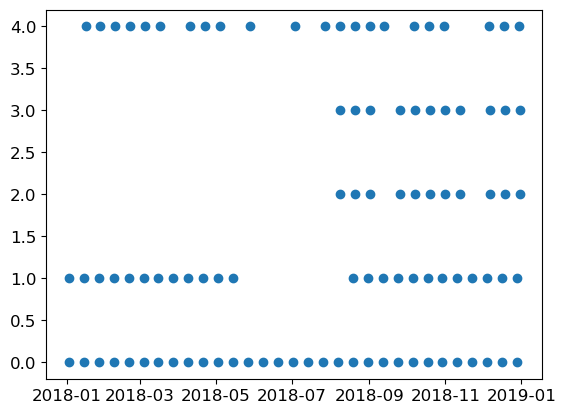

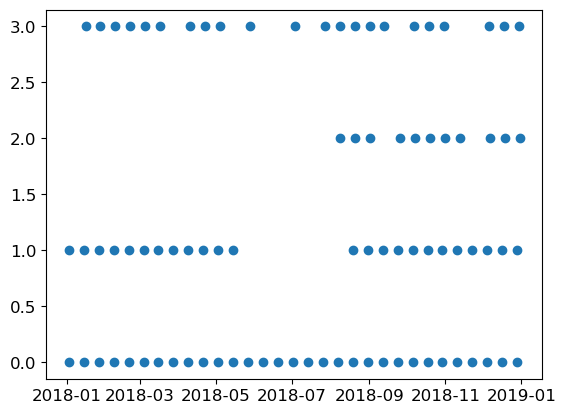

In [14]:
#Get_Data

print(f'{projname}: {year}')
readyproducts = hyp3.find_jobs()
readyproducts = readyproducts.filter_jobs(succeeded=True,include_expired=False)
readyprodnames = [i.job_parameters['granules'][0] for i in readyproducts]

results = getasfresults(WTKstr,year,showplots=True,showstats=True)
dojobs = getasfresults(WTKstr,year)
resultnames = [i.properties['sceneName'] for i in results]

remcount = 0
for i,job in enumerate(results):
    jobscene = job.properties['sceneName']
    dojobnames = np.array([i.properties['sceneName'] for i in dojobs])
    job = dojobs[np.where(dojobnames==jobscene)[0][0]]
    # othercount += 1
    if job.properties['sceneName'] in readyprodnames:
        # print(i)
        dojobs.remove(job)
        remcount += 1
        

print(f'jobs already ready: {remcount}')
print(f'Number of jobs to do: {len(dojobs)}')

In [36]:
#Submit jobs for RTC processing

projectname = f'{projname}_{year%1000}'

granules = [i.properties['sceneName'] for i in dojobs]

submitjobs = True
if submitjobs:
    rtc_jobs = Batch()
    for g in granules:
        rtc_jobs += hyp3.submit_rtc_job(g, name=projectname)
    print(rtc_jobs)
else:
    print("Note: no job submitted as submitjobs is currently 'False'")
print(hyp3.my_info()['quota'])

24 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 24 pending.
{'max_jobs_per_month': 1000, 'remaining': 261}


In [16]:
#do failed jobs if necessary (set to True)

dofailedjob = False
if dofailedjob:
    hyp3.submit_rtc_job('S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318', name = projectname)

In [39]:
print(hyp3.my_info()['quota'])

{'max_jobs_per_month': 1000, 'remaining': 401}


## Utility Functions

download images\
extract images\
reproject and clip to wtk\
convert to db\
do this sequentially

In [6]:
#convert utility
def converttodb(file):
    ds = gdal.Open(file, gdal.GA_Update)
    data = ds.ReadAsArray()

    data[data<1e-6]=1e-6
    
    data = 10*np.log10(data)
    data[data==-np.inf]=-60
    ds.GetRasterBand(1).WriteArray(data)
    ds = None

#download utility:
def extracttif(inloc,outloc,pol='VV',convert=True):
    """expect pol to be 'VV','VH','HH', or 'HV' 
    convert will convert this to db"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infile = glob.glob(f'{inloc}*')
    endstr = pol+'.tif'
    for file in infile:
        # print(file)
        # namelist = 
        with ZipFile(file) as z:
            # print(z.namelist)
            z = ZipFile(file)
            zname = [name for name in z.namelist() if name[-6:]==endstr]
            if len(zname)>0:
                zname = zname[0]
        
                filename = os.path.basename(zname)
                source = z.open(zname)
                targetname = os.path.join(outloc, filename)
                target = open(targetname, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)
                target.close()
                if convert:
                    converttodb(targetname)
        # os.remove(file)
        

In [7]:
#CLIPPING TOOLS

def wtkparse(wtk):
    """It's not weird if it works"""
    wtk = wtk.split("'")
    wtk = wtk[0].split("(")[2]
    wtk = wtk.split(")")[0]
    wtk = wtk.split(',')
    wtk = [s.split(' ') for s in wtk]
    wtk = np.array([[float(ss) for ss in s] for s in wtk])
    return(wtk)

def CoordConvert(points,inproj,outproj,ptparse=False):
    """Convert coordinate grid from one projection to another
    if converting from 4326, then points should be ordered lon,lat"""

    if ptparse:
        points = wtkparse(points)

    if type(inproj)==str:
        inproj=int(inproj)
    if type(outproj)==str:
        outproj=int(outproj)

    epsgin = osr.SpatialReference()
    epsgin.ImportFromEPSG(inproj)   
    epsgout = osr.SpatialReference()
    epsgout.ImportFromEPSG(outproj)

    convert = osr.CoordinateTransformation(epsgin, epsgout)
    points = np.array(points)
    
    for i,x in enumerate(points):
        newpt = convert.TransformPoint(x[1],x[0])
        points[i,0],points[i,1]=newpt[0],newpt[1]
        
    return points

def wtktobox(wtk,epsgn,srcproj = 4326):
    """epsgn is the epsg of the tif file
    output will be ulx uly lrx lry"""
    epsgn = int(epsgn)
    srcproj = int(srcproj)
    xyp = CoordConvert(wtk,4326,epsgn,ptparse=True)
    ulx,uly = np.min(xyp[:,0]),np.max(xyp[:,1])
    lrx,lry = np.max(xyp[:,0]),np.min(xyp[:,1])
    return ulx,uly,lrx,lry

def testEPSG(inloc):
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    # if str(outloc)[-1]!='/':
        # outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    for file in infiles:
        ds=gdal.Open(file)
        proj = osr.SpatialReference(wkt=ds.GetProjection())
        dsproj = proj.GetAttrValue('AUTHORITY',1)
        ds = None
        print(dsproj)
# testEPSG(products_path)

def getEPSG(file):
    ds=gdal.Open(file)
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    dsproj = proj.GetAttrValue('AUTHORITY',1)
    ds = None
    return dsproj

def identify_epsgs(fileloc):
    """Identify EPSG systems used in this. By default this will return the most commonly one."""
    if str(fileloc)[-1]!='/':
        fileloc = str(fileloc)+'/'
    filelist = glob.glob(f'{fileloc}*')
    eplist = []
    for file in filelist:
        eplist.append(getEPSG(file))
        # print(eplist[-1])
        # print(file)
    epu,epc = np.unique(eplist,return_counts=True)
    for i,ep in enumerate(epu):
        count = epc[i]
        print(f'Found EPSG:{ep}, count: {count}')
    return epu[np.where(epc==np.max(epc))[0]][0]

def reproject(wtk,epsgn,inloc,outloc,res=30,convert_to_db=False):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    # c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)
        
        if convert_to_db:
            converttodb(ofile)

## Get Data

In [8]:
#Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# EPSGn = '32607'
pols = ['VV','VH']

autoEPSG=True #use this to pull the first projection and use that as your projection for all images

# First check if jobs are running
class Error(Exception):
    """Base class for other exceptions"""
    pass
class stillrunningError(Error):
    """raised when jobs are still running"""
    pass

running = len(hyp3.find_jobs(status_code=["RUNNING"]))
running += len(hyp3.find_jobs(status_code=["PENDING"]))

if running > 0:
    print('Jobs still running!')
    raise stillrunningError
else:
    print('No jobs running, all clear')

No jobs running, all clear


In [15]:
# Get the list of jobs to download
usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
joblen = len(results)-1

t = time.time()
count = 0
for i,job in enumerate(joblist):

    jobname = job.job_parameters['granules'][0]

    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        job.download_files(download_path)
        for pol in pols:
            # print(pol)
            extracttif(download_path,products_path,pol=pol,convert=False)
            if autoEPSG:
                if (count == 1) and (pol == pols[0]):
                    fileg = glob.glob(f'{str(products_path)}/*.tif')
                    EPSGn = getEPSG(fileg[0])
                    print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            os.system(f'rm {str(products_path)}/*.tif')
            time.sleep(3)
        os.system(f'rm {str(download_path)}/*.zip')
        
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

S1A_IW_20180102T162912_DVP_RTC30_G_gpuned_93C3.zip:   0%|          | 0/454064517 [00:00<?, ?it/s]

32605


S1A_IW_20180102T162937_DVP_RTC30_G_gpuned_B92D.zip:   0%|          | 0/470780501 [00:00<?, ?it/s]

S1A_IW_20180114T162912_DVP_RTC30_G_gpuned_082C.zip:   0%|          | 0/471503510 [00:00<?, ?it/s]

S1B_IW_20180116T033517_DVP_RTC30_G_gpuned_C88B.zip:   0%|          | 0/505104559 [00:00<?, ?it/s]

S1A_IW_20180114T162938_DVP_RTC30_G_gpuned_28C3.zip:   0%|          | 0/453508674 [00:00<?, ?it/s]

S1A_IW_20180126T162912_DVP_RTC30_G_gpuned_9E28.zip:   0%|          | 0/471250908 [00:00<?, ?it/s]

S1A_IW_20180126T162938_DVP_RTC30_G_gpuned_5E86.zip:   0%|          | 0/453713259 [00:00<?, ?it/s]

S1B_IW_20180128T033517_DVP_RTC30_G_gpuned_362A.zip:   0%|          | 0/504638005 [00:00<?, ?it/s]

S1A_IW_20180207T162912_DVP_RTC30_G_gpuned_7A4E.zip:   0%|          | 0/471004636 [00:00<?, ?it/s]

Current job: 10/87, time elapsed: 2.91 min, time remaining: 1.35 min


S1A_IW_20180207T162937_DVP_RTC30_G_gpuned_7BDE.zip:   0%|          | 0/453683207 [00:00<?, ?it/s]

S1B_IW_20180209T033517_DVP_RTC30_G_gpuned_A851.zip:   0%|          | 0/504208740 [00:00<?, ?it/s]

S1A_IW_20180219T162911_DVP_RTC30_G_gpuned_2FCF.zip:   0%|          | 0/471386555 [00:00<?, ?it/s]

S1A_IW_20180219T162937_DVP_RTC30_G_gpuned_420D.zip:   0%|          | 0/452761450 [00:00<?, ?it/s]

S1B_IW_20180221T033516_DVP_RTC30_G_gpuned_D231.zip:   0%|          | 0/504835990 [00:00<?, ?it/s]

S1A_IW_20180303T162911_DVP_RTC30_G_gpuned_7C53.zip:   0%|          | 0/471508866 [00:00<?, ?it/s]

S1B_IW_20180305T033516_DVP_RTC30_G_gpuned_386B.zip:   0%|          | 0/504243669 [00:00<?, ?it/s]

S1A_IW_20180303T162937_DVP_RTC30_G_gpuned_B604.zip:   0%|          | 0/452337667 [00:00<?, ?it/s]

S1A_IW_20180315T162911_DVP_RTC30_G_gpuned_2CAF.zip:   0%|          | 0/472367062 [00:00<?, ?it/s]

S1A_IW_20180315T162937_DVP_RTC30_G_gpuned_57D1.zip:   0%|          | 0/454063085 [00:00<?, ?it/s]

Current job: 20/87, time elapsed: 6.26 min, time remaining: 2.38 min


S1B_IW_20180317T033516_DVP_RTC30_G_gpuned_D845.zip:   0%|          | 0/507130151 [00:00<?, ?it/s]

S1A_IW_20180327T162912_DVP_RTC30_G_gpuned_8F81.zip:   0%|          | 0/471223443 [00:00<?, ?it/s]

S1A_IW_20180327T162937_DVP_RTC30_G_gpuned_3CEE.zip:   0%|          | 0/453403248 [00:00<?, ?it/s]

S1A_IW_20180408T162912_DVP_RTC30_G_gpuned_EAF7.zip:   0%|          | 0/471519000 [00:00<?, ?it/s]

S1A_IW_20180408T162938_DVP_RTC30_G_gpuned_A7DD.zip:   0%|          | 0/452751591 [00:00<?, ?it/s]

S1B_IW_20180410T033517_DVP_RTC30_G_gpuned_AB4F.zip:   0%|          | 0/507186285 [00:00<?, ?it/s]

S1A_IW_20180420T162912_DVP_RTC30_G_gpuned_1010.zip:   0%|          | 0/472476499 [00:00<?, ?it/s]

S1A_IW_20180420T162938_DVP_RTC30_G_gpuned_F9D4.zip:   0%|          | 0/453717217 [00:00<?, ?it/s]

S1A_IW_20180502T162913_DVP_RTC30_G_gpuned_1080.zip:   0%|          | 0/472480884 [00:00<?, ?it/s]

S1B_IW_20180422T033518_DVP_RTC30_G_gpuned_7DAB.zip:   0%|          | 0/506454556 [00:00<?, ?it/s]

Current job: 30/87, time elapsed: 9.58 min, time remaining: 2.93 min


S1B_IW_20180504T033518_DVP_RTC30_G_gpuned_E05A.zip:   0%|          | 0/506623546 [00:00<?, ?it/s]

S1A_IW_20180502T162939_DVP_RTC30_G_gpuned_FB5E.zip:   0%|          | 0/454683078 [00:00<?, ?it/s]

S1A_IW_20180514T162914_DVP_RTC30_G_gpuned_4295.zip:   0%|          | 0/473527482 [00:00<?, ?it/s]

S1A_IW_20180526T162914_DVP_RTC30_G_gpuned_8F4E.zip:   0%|          | 0/639490143 [00:00<?, ?it/s]

S1A_IW_20180514T162939_DVP_RTC30_G_gpuned_89F9.zip:   0%|          | 0/455187328 [00:00<?, ?it/s]

S1A_IW_20180607T162915_DVP_RTC30_G_gpuned_765C.zip:   0%|          | 0/638964912 [00:00<?, ?it/s]

S1B_IW_20180528T033519_DVP_RTC30_G_gpuned_6496.zip:   0%|          | 0/507358179 [00:00<?, ?it/s]

S1A_IW_20180619T162916_DVP_RTC30_G_gpuned_CE82.zip:   0%|          | 0/636671428 [00:00<?, ?it/s]

S1A_IW_20180701T162916_DVP_RTC30_G_gpuned_7C89.zip:   0%|          | 0/637028571 [00:00<?, ?it/s]

S1B_IW_20180703T033522_DVP_RTC30_G_gpuned_EEA4.zip:   0%|          | 0/505921006 [00:00<?, ?it/s]

Current job: 40/87, time elapsed: 13.25 min, time remaining: 3.18 min


S1A_IW_20180725T162918_DVP_RTC30_G_gpuned_DBD4.zip:   0%|          | 0/633782597 [00:00<?, ?it/s]

S1A_IW_20180713T162917_DVP_RTC30_G_gpuned_683E.zip:   0%|          | 0/635982081 [00:00<?, ?it/s]

S1B_IW_20180727T033523_DVP_RTC30_G_gpuned_AE58.zip:   0%|          | 0/504101211 [00:00<?, ?it/s]

S1B_IW_20180808T033524_DVP_RTC30_G_gpuned_A934.zip:   0%|          | 0/505486268 [00:00<?, ?it/s]

S1A_IW_20180806T162919_DVP_RTC30_G_gpuned_1824.zip:   0%|          | 0/635088755 [00:00<?, ?it/s]

S1A_IW_20180808T161257_DVP_RTC30_G_gpuned_1BEC.zip:   0%|          | 0/473636343 [00:00<?, ?it/s]

S1A_IW_20180818T162919_DVP_RTC30_G_gpuned_7138.zip:   0%|          | 0/471350124 [00:00<?, ?it/s]

S1A_IW_20180818T162945_DVP_RTC30_G_gpuned_534F.zip:   0%|          | 0/452047909 [00:00<?, ?it/s]

S1A_IW_20180820T161258_DVP_RTC30_G_gpuned_1BA1.zip:   0%|          | 0/472700071 [00:00<?, ?it/s]

S1B_IW_20180820T033525_DVP_RTC30_G_gpuned_C681.zip:   0%|          | 0/304081602 [00:00<?, ?it/s]

Current job: 50/87, time elapsed: 16.64 min, time remaining: 2.99 min


S1A_IW_20180830T162920_DVP_RTC30_G_gpuned_77CE.zip:   0%|          | 0/471040372 [00:00<?, ?it/s]

S1A_IW_20180830T162946_DVP_RTC30_G_gpuned_82D3.zip:   0%|          | 0/454401009 [00:00<?, ?it/s]

S1B_IW_20180901T033525_DVP_RTC30_G_gpuned_F203.zip:   0%|          | 0/304886229 [00:00<?, ?it/s]

S1A_IW_20180911T162920_DVP_RTC30_G_gpuned_A8A0.zip:   0%|          | 0/471725730 [00:00<?, ?it/s]

S1A_IW_20180901T161259_DVP_RTC30_G_gpuned_BDA9.zip:   0%|          | 0/456331869 [00:00<?, ?it/s]

S1A_IW_20180911T162946_DVP_RTC30_G_gpuned_4C63.zip:   0%|          | 0/453796462 [00:00<?, ?it/s]

S1B_IW_20180913T033526_DVP_RTC30_G_gpuned_FC58.zip:   0%|          | 0/506397714 [00:00<?, ?it/s]

S1A_IW_20180923T162921_DVP_RTC30_G_gpuned_010B.zip:   0%|          | 0/471555925 [00:00<?, ?it/s]

S1A_IW_20180923T162947_DVP_RTC30_G_gpuned_0EB6.zip:   0%|          | 0/453167204 [00:00<?, ?it/s]

S1A_IW_20180925T161259_DVP_RTC30_G_gpuned_83B6.zip:   0%|          | 0/473988116 [00:00<?, ?it/s]

Current job: 60/87, time elapsed: 19.83 min, time remaining: 2.48 min


S1A_IW_20181005T162921_DVP_RTC30_G_gpuned_6D2C.zip:   0%|          | 0/470997877 [00:00<?, ?it/s]

S1A_IW_20181005T162947_DVP_RTC30_G_gpuned_C198.zip:   0%|          | 0/452912247 [00:00<?, ?it/s]

S1A_IW_20181007T161259_DVP_RTC30_G_gpuned_FEB6.zip:   0%|          | 0/473522266 [00:00<?, ?it/s]

S1B_IW_20181007T033526_DVP_RTC30_G_gpuned_1F40.zip:   0%|          | 0/505258950 [00:00<?, ?it/s]

S1A_IW_20181017T162921_DVP_RTC30_G_gpuned_8613.zip:   0%|          | 0/471192104 [00:00<?, ?it/s]

S1B_IW_20181019T033526_DVP_RTC30_G_gpuned_D71A.zip:   0%|          | 0/505497637 [00:00<?, ?it/s]

S1A_IW_20181017T162947_DVP_RTC30_G_gpuned_475A.zip:   0%|          | 0/452111361 [00:00<?, ?it/s]

S1A_IW_20181019T161300_DVP_RTC30_G_gpuned_0C88.zip:   0%|          | 0/473507779 [00:00<?, ?it/s]

S1A_IW_20181029T162921_DVP_RTC30_G_gpuned_7BBC.zip:   0%|          | 0/470728353 [00:00<?, ?it/s]

S1B_IW_20181031T033526_DVP_RTC30_G_gpuned_85E3.zip:   0%|          | 0/505724584 [00:00<?, ?it/s]

Current job: 70/87, time elapsed: 23.02 min, time remaining: 1.73 min


S1A_IW_20181029T162947_DVP_RTC30_G_gpuned_35E9.zip:   0%|          | 0/452965427 [00:00<?, ?it/s]

S1A_IW_20181031T161300_DVP_RTC30_G_gpuned_72FE.zip:   0%|          | 0/456770893 [00:00<?, ?it/s]

S1A_IW_20181110T162921_DVP_RTC30_G_gpuned_BD10.zip:   0%|          | 0/469685843 [00:00<?, ?it/s]

S1A_IW_20181110T162947_DVP_RTC30_G_gpuned_A9A6.zip:   0%|          | 0/452636328 [00:00<?, ?it/s]

S1A_IW_20181112T161259_DVP_RTC30_G_gpuned_26B5.zip:   0%|          | 0/473719056 [00:00<?, ?it/s]

S1A_IW_20181122T162946_DVP_RTC30_G_gpuned_FAA0.zip:   0%|          | 0/453997780 [00:00<?, ?it/s]

S1A_IW_20181122T162921_DVP_RTC30_G_gpuned_82D6.zip:   0%|          | 0/470895917 [00:00<?, ?it/s]

S1A_IW_20181204T162946_DVP_RTC30_G_gpuned_335B.zip:   0%|          | 0/452594925 [00:00<?, ?it/s]

S1A_IW_20181204T162920_DVP_RTC30_G_gpuned_187B.zip:   0%|          | 0/471633737 [00:00<?, ?it/s]

S1A_IW_20181206T161259_DVP_RTC30_G_gpuned_4BED.zip:   0%|          | 0/474299135 [00:00<?, ?it/s]

Current job: 80/87, time elapsed: 26.12 min, time remaining: 0.77 min


S1B_IW_20181206T033526_DVP_RTC30_G_gpuned_3ADC.zip:   0%|          | 0/506663783 [00:00<?, ?it/s]

S1A_IW_20181216T162920_DVP_RTC30_G_gpuned_D79F.zip:   0%|          | 0/470941128 [00:00<?, ?it/s]

S1A_IW_20181216T162946_DVP_RTC30_G_gpuned_9C62.zip:   0%|          | 0/454814632 [00:00<?, ?it/s]

S1B_IW_20181218T033525_DVP_RTC30_G_gpuned_4E5A.zip:   0%|          | 0/506653642 [00:00<?, ?it/s]

S1A_IW_20181218T161258_DVP_RTC30_G_gpuned_41AD.zip:   0%|          | 0/474377764 [00:00<?, ?it/s]

S1A_IW_20181228T162919_DVP_RTC30_G_gpuned_089F.zip:   0%|          | 0/470960571 [00:00<?, ?it/s]

S1A_IW_20181228T162945_DVP_RTC30_G_gpuned_61DC.zip:   0%|          | 0/452912823 [00:00<?, ?it/s]

S1B_IW_20181230T033525_DVP_RTC30_G_gpuned_5FA2.zip:   0%|          | 0/506287031 [00:00<?, ?it/s]

S1A_IW_20181230T161258_DVP_RTC30_G_gpuned_C4A2.zip:   0%|          | 0/456068460 [00:00<?, ?it/s]

EPSG number records:

* Denali_h: 32605?
* Harding: 32605
* Juneau: 32608

## Create some metadata

I want: a set of lists that have (with each proper corresponding entry), image name (granule I guess), date (date will be used to match), orbit pf, and orbit unique pf number

In [11]:
def getSARdate(file,returndatestring=False):
    '''Obtains the date of the start of a SAR acquisition, returns as a datetime
    or a string.'''

    file = str(file)
    query = "_????????T??????_"
    seqquery = str(query)
    seqquery.replace('?','[0-9]')

    substrings = fnmatch.filter((file[i:i+len(query)] for i in range(len(file) - len(query))), seqquery)
    dtstr = substrings[0][1:-1].split('T')
    
    dtint = [dtstr[0][0:4],dtstr[0][4:6],dtstr[0][6:8],dtstr[1][0:2],dtstr[1][2:4],dtstr[1][4:6]]
    dtint = [int(i)for i in dtint]
    dtimg = datetime(dtint[0],dtint[1],dtint[2],dtint[3],dtint[4],dtint[5])

    if returndatestring:
        dtstr = dtstr[0]+dtstr[1]
        return dtimg,dtstr
    else:
        return dtimg

In [12]:
#NOTE: Results must already be defined and refined

for usepol in pols:

    mnamelist = []
    mdatelist = []
    mpflist = []
    mpfulist = []

    files = (clipped_path/usepol).glob('*.tif')
    filelist = []
    pdatelist = []
    pnamelist = []
    # print(results)

    for f in files:
        # print(f)
        pdatelist.append(getSARdate(f))
        filelist.append(f)

    # print(pdatelist)
    pdatelist=np.array(pdatelist)
    filelist = np.array(filelist)
    # print(len(products))
    # print(len(pdatelist))
    for res in results:
        res = res.properties
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        pind = np.where(rdate==pdatelist)
        # print(pind)
        if len(pind)==1:
            pind = pind[0][0]
            pnamelist.append(str(filelist[pind]))
            rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
            mpflist.append(rpf)
            mnamelist.append(res['sceneName'])
            mdatelist.append(rdate)
        else:
            print('WARNING: Missing product')
            print(res['sceneName'])

    pfunique = np.unique(mpflist)
    mpfulist = [np.where(pfunique==i)[0][0] for i in mpflist]
    arraykey = ['arraykey','pnamelist','mnamelist','mdatelist','mpflist','mpfulist']

    arraykey = np.asanyarray(arraykey)
    pnamelist = np.array(pnamelist)
    mnamelist = np.array(mnamelist)
    mdatelist = np.array(mdatelist)
    mpflist = np.array(mpflist)
    mpfulist = np.array(mpfulist)

    mdatelist,pnamelist,mnamelist,mpflist,mpfulist = zip(*sorted(zip(mdatelist,pnamelist,mnamelist,mpflist,mpfulist)))

    np.save(f'{str(data_dir)}/imgmeta_{usepol}.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
